<a href="https://colab.research.google.com/github/Julian6262/the_founder/blob/main/home%20work%2020/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В домашней работе необходимо выполнить следующее задание:

1. Подготовьте датасет с [писателями Русской литературы](https://storage.yandexcloud.net/academy.ai/russian_literature.zip) для обучения модели `Embedding` по аналогии с уроком [20.2](https://colab.research.google.com/drive/1KEFUgyBcqGaXGZEU-7MHENn5RH_AIvfH)
2. Подгрузите веса Наташи как в уроке [20.3](https://colab.research.google.com/drive/1g_dX1XpRY--X6EjFflCC0717p9_9Y1SP) для эмбендинга.
3. Заморозьте слой эмбединга.
4. Выберите любых 5 писателей и обучите модель на них, не забудьте про балансировку (предварительно выделите 10% датасета на проверочную выборку и 10% на тестовую). Выбирайте писателей с большими объемами текстов, что даст большее число примеров для обучения.
5. Добейтесь средней точности более 70% на тестовых образцах. Получите 3 балла.
6. Если сможете добиться точности более 85% получите 4 балла.
7. Хотите 5 баллов независимо от точности? Изучите самостоятельно и примените токенизатор [Razdel](https://github.com/natasha/razdel#usage) для данной задачи, вместо встроенного токенизатора для Keras.

**Подсказка**. Так как проверка задания проводиться по средней точности на тестовых образцах (вычисляем по диагонали матрицы ошибок), то для улучшения данного показателя используйте колбэк функцию `keras.callbacks.ModelCheckpoint` из урока [19.2](https://colab.research.google.com/drive/1x2qd4MvG3ODgNrE2uqxRAZB70dGgdGft) для сохранения лучшей эпохи.

**Подсказка 2**. Часто при работе с текстовыми данными вы можете заметить, что при использовании параметра `validation_split`, в методе `fit()`, точность на проверочной выборке ведет себя странно. В этом случае выделите проверочную выборку самостоятельно и используйте ее с помощью параметра `validation_data`.

In [ ]:
!pip install navec

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/russian_literature.zip
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [ ]:
!unzip -qo "russian_literature" -d ./dataset

In [ ]:
import glob
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout
from navec import Navec
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
CLASS_LIST=["Dostoevsky", "Tolstoy", "Turgenev", "Chekhov", "Lermontov", "Blok", "Pushkin", "Gogol", "Gorky", "Herzen", "Bryusov", "Nekrasov" ]

In [ ]:
all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
  all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
  for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
    with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
                text = f.read()

    all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

In [ ]:
embedding_dim = 300    # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 10000      # Количество слов, рассматриваемых как признаки

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=max_words,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)


# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_texts.values())

In [ ]:
seq_train = tokenizer.texts_to_sequences(all_texts.values())

In [ ]:
total = sum(len(i) for i in seq_train)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 5938471 слов


In [ ]:
print('Общая выборка по писателям (по словам):')
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train[cls])} слов, доля в общей базе: {len(seq_train[cls])/total*100 :.2f}%')

Общая выборка по писателям (по словам):
Dostoevsky - 1779919 слов, доля в общей базе: 29.97%
Tolstoy - 1456418 слов, доля в общей базе: 24.53%
Turgenev - 365152 слов, доля в общей базе: 6.15%
Chekhov - 291031 слов, доля в общей базе: 4.90%
Lermontov - 55465 слов, доля в общей базе: 0.93%
Blok - 89445 слов, доля в общей базе: 1.51%
Pushkin - 214000 слов, доля в общей базе: 3.60%
Gogol - 341263 слов, доля в общей базе: 5.75%
Gorky - 671672 слов, доля в общей базе: 11.31%
Herzen - 190526 слов, доля в общей базе: 3.21%
Bryusov - 430108 слов, доля в общей базе: 7.24%
Nekrasov - 53472 слов, доля в общей базе: 0.90%


In [ ]:
# список, отсортированный по количеству слов у авторов
sorted_lst = sorted(((CLASS_LIST[i], len(k)) for i, k in enumerate(seq_train)), key=lambda x: x[1], reverse=True)

# Берем 5 первых авторов
class_list, texts_len = zip(*sorted_lst[:5])
print("Первые 5 авторов с большими объемами текстов:", class_list)
print("Количество слов у данных авторов соответственно:", texts_len)

Первые 5 авторов с большими объемами текстов: ('Dostoevsky', 'Tolstoy', 'Gorky', 'Bryusov', 'Turgenev')
Количество слов у данных авторов соответственно: (1779919, 1456418, 671672, 430108, 365152)


In [ ]:
# Берем 5 писателей с большими объемами текстов и обрезаем до одной длины
min_len = min(texts_len)
print("Обрезаем до длины:", min_len)

seq_train_balance = [seq_train[CLASS_LIST.index(author)][:min_len] for author in class_list]

Обрезаем до длины: 365152


In [ ]:
total = sum(len(i) for i in seq_train_balance)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 1825760 слов


In [ ]:
print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in class_list:
    cls = class_list.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

Общая выборка по писателям (по словам):
Dostoevsky - 365152 слов, доля в общей базе: 20.00%
Tolstoy - 365152 слов, доля в общей базе: 20.00%
Gorky - 365152 слов, доля в общей базе: 20.00%
Bryusov - 365152 слов, доля в общей базе: 20.00%
Turgenev - 365152 слов, доля в общей базе: 20.00%
Среднее значение слов:  365152.0
Медианное значение слов:  365152.0


In [ ]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах


def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]


def seq_vectorize(
        seq_list,  # Последовательность
        test_split,  # Доля на тестовую сборку
        class_list,  # Список классов
        win_size,  # Ширина скользящего окна
        step  # Шаг скользящего окна
):
    # Списки для результирующих данных
    x_train, y_train, x_test, y_test, x_val, y_val = [], [], [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        gate_split = int(len(seq_list[cls]) * (1 - test_split * 2))
        gate_split2 = int(len(seq_list[cls])) - gate_split

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step)
        vectors_test = seq_split(seq_list[cls][gate_split:gate_split + gate_split2 // 2], win_size, step)
        vectors_val = seq_split(seq_list[cls][gate_split + gate_split2 // 2:], win_size, step)

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_test += vectors_test
        x_val += vectors_val

        y_train += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_test)
        y_val += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_val)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test), np.array(x_val), np.array(y_val)

In [ ]:
# 0.1 - выделяется для тестовой и валидационной, каждой по 0.1
x_train, y_train, x_test, y_test, x_val, y_val = seq_vectorize(seq_train_balance, 0.1, class_list, WIN_SIZE, WIN_STEP)

In [ ]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')

Форма входных данных для обучающей выборки: (14560, 1000)
Форма выходных данных (меток) для обучающей выборки: (14560, 5)


In [ ]:
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для тестовой выборки: (1780, 1000)
Форма выходных данных (меток) для тестовой выборки: (1780, 5)


In [ ]:
print(f'Форма входных данных для проверочной выборки: {x_val.shape}')
print(f'Форма выходных данных (меток) для проверочной выборки: {y_val.shape}')

Форма входных данных для проверочной выборки: (1780, 1000)
Форма выходных данных (меток) для проверочной выборки: (1780, 5)


In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model.add(BatchNormalization())
model.add(Dense(60, activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(len(class_list), activation='softmax'))

In [ ]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:
# Загрузка весов
word_index = tokenizer.word_index
embeddings_index = navec

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = '{epoch:02d}-{val_accuracy:.2f}.keras',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

history = model.fit(x_train, y_train, epochs=50, batch_size=256, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/50
57/57 [==============================] - 8s 56ms/step - loss: 0.8498 - accuracy: 0.7157 - val_loss: 2.7970 - val_accuracy: 0.3006
Epoch 2/50
57/57 [==============================] - 3s 50ms/step - loss: 0.0253 - accuracy: 0.9913 - val_loss: 4.6427 - val_accuracy: 0.3461
Epoch 3/50
57/57 [==============================] - 3s 50ms/step - loss: 0.0075 - accuracy: 0.9979 - val_loss: 4.0102 - val_accuracy: 0.4292
Epoch 4/50
57/57 [==============================] - 3s 52ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 2.9439 - val_accuracy: 0.5219
Epoch 5/50
57/57 [==============================] - 3s 50ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 1.5513 - val_accuracy: 0.6567
Epoch 6/50
57/57 [==============================] - 3s 56ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.8249 - val_accuracy: 0.7764
Epoch 7/50
57/57 [==============================] - 3s 50ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.5635 - val_accuracy: 0.8399
Epoch 8/50
57

In [ ]:
# Вывод графиков точности и ошибки
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()


    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

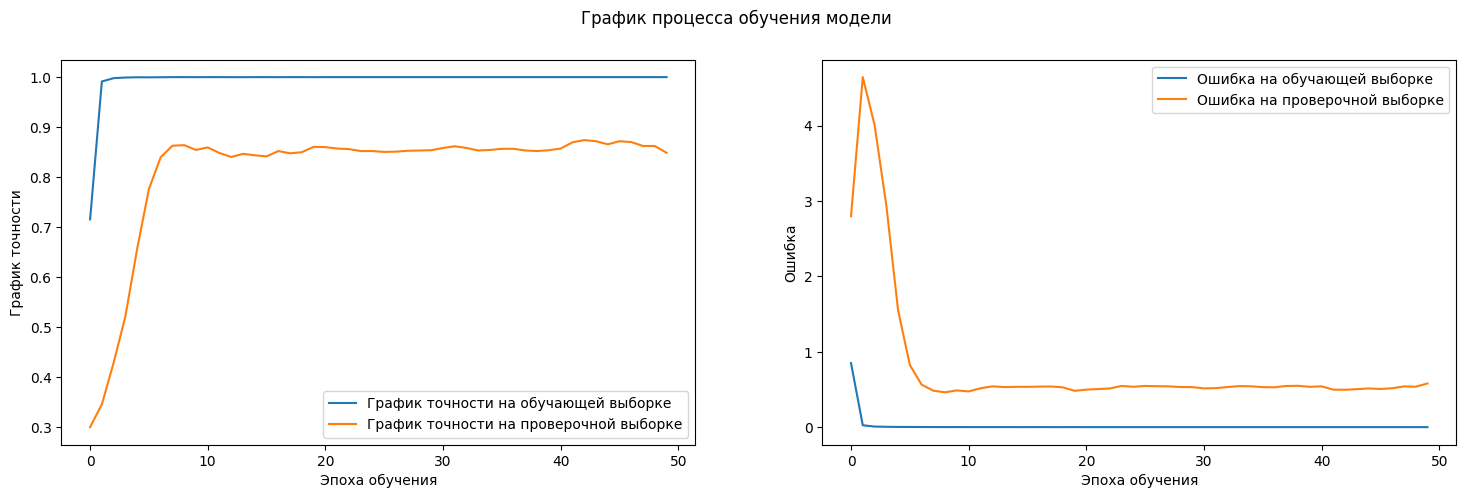

In [ ]:
show_plot(history)

56/56 [==============================] - 0s 4ms/step


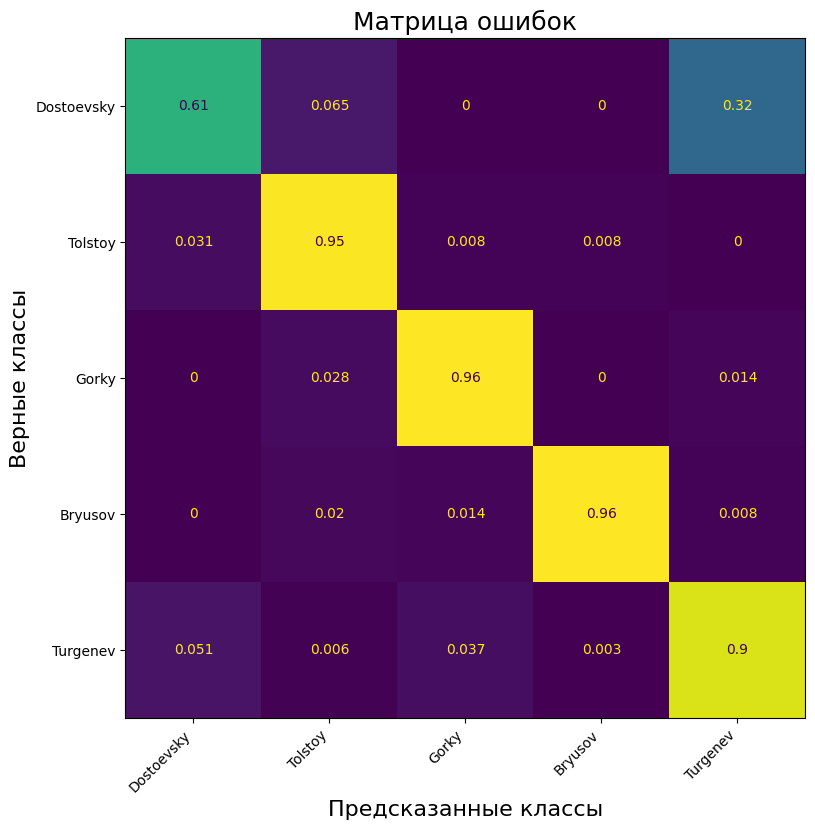


Средняя точность распознавания:  88%


In [ ]:
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, class_list)

In [ ]:
# Загрузим сохраненную модель
model = keras.saving.load_model('43-0.87.keras')

56/56 [==============================] - 0s 4ms/step


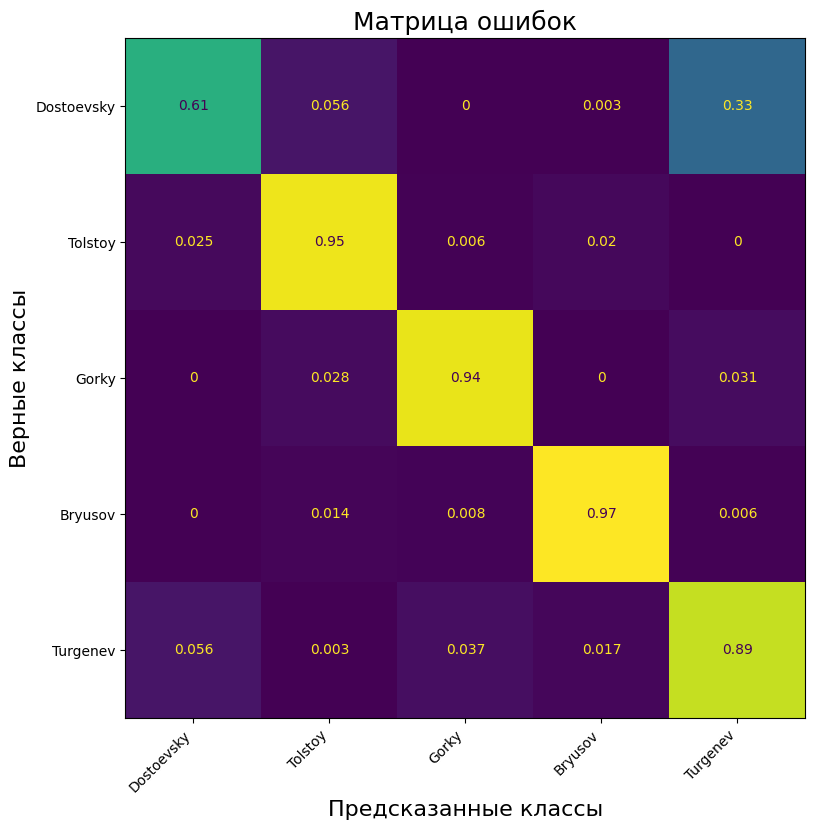


Средняя точность распознавания:  87%


In [ ]:
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, class_list)

**С загруженной моделью с максимальной точностью, результат почти такой же**